## Package importing

In [1]:
from fastai.vision.all import *
from pathlib import Path

In [2]:
path = Path.cwd()/'../datasets/bears'
path

Path('/home/fastai-2020-lalkrishna/My-files/Projects/../datasets/bears')

## Data Loading

In [2]:
def get_y(path): return path.parent.name.split(' ')

# get_y(get_image_files(path)[0])

In [4]:
bears = DataBlock(
        blocks = (ImageBlock, MultiCategoryBlock),
        splitter = RandomSplitter(valid_pct=0.3),
        get_items = get_image_files,
        get_y = get_y,
        item_tfms = Resize(400),
        batch_tfms= aug_transforms())

In [5]:
bears.summary(path)

Setting-up type transforms pipelines
Found 521 items
2 datasets of sizes 365,156
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_y -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/fastai-2020-lalkrishna/My-files/Projects/../datasets/bears/black/00000023.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=333x500
  Pipeline: get_y -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}
    starting from
      /home/fastai-2020-lalkrishna/My-files/Projects/../datasets/bears/black/00000023.jpg
    applying get_y gives
      [black]
    applying MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorMultiCategory([0])
    applying OneHotEncode -- {'c': None} gives
      TensorMultiCategory([1., 0., 0.])

Final sample: (PILImage mode=RGB size=333x500, TensorMultiCa

In [7]:
data = bears.dataloaders(path)

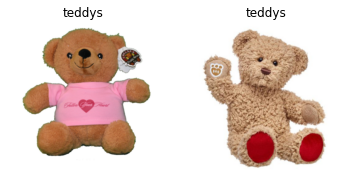

In [7]:
data.valid.show_batch(max_n = 2)

#### Image Augmentation

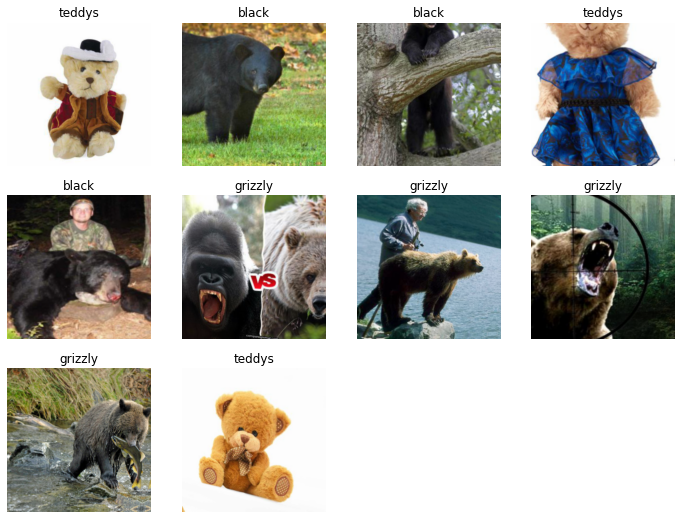

In [8]:
data.train.show_batch(max_n = 10, unique=False)

In [9]:
x, y = data.one_batch()
x.shape, y.shape

(torch.Size([64, 3, 400, 400]), torch.Size([64, 3]))

(<AxesSubplot:>, TensorMultiCategory([0., 1., 0.], device='cuda:0'))

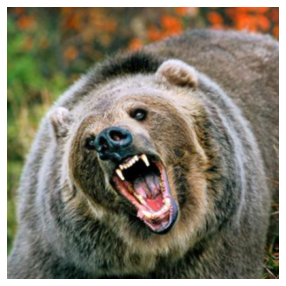

In [10]:
x[53].show(), y[53]

### training

In [8]:
model = cnn_learner(data, resnet18, metrics=partial(accuracy_multi, thresh=.75))
model.loss_func

FlattenedLoss of BCEWithLogitsLoss()

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.001737800776027143)

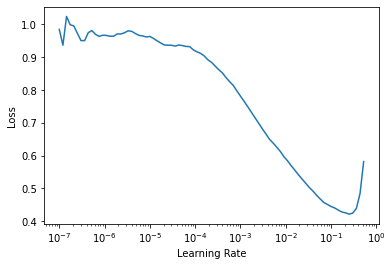

In [9]:
model.lr_find()

In [10]:
from fastai.callback.fp16 import *
model.fine_tune(20, 1e-2, 5)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.705418,0.343764,0.895299,00:07
1,0.498605,0.115677,0.980769,00:06
2,0.382092,0.078716,0.987179,00:06
3,0.312357,0.078846,0.982906,00:06
4,0.252943,0.064315,0.989316,00:06


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.066154,0.149057,0.965812,00:09
1,0.047371,0.164696,0.967949,00:07
2,0.044637,0.145260,0.972222,00:07
3,0.037740,0.108415,0.985043,00:07
4,0.036924,0.142187,0.978633,00:07
5,0.038331,0.873912,0.903846,00:07
6,0.057890,0.722025,0.944445,00:07
7,0.064452,0.166145,0.970086,00:07
8,0.061135,0.078852,0.978633,00:07
9,0.057375,0.117556,0.967949,00:07


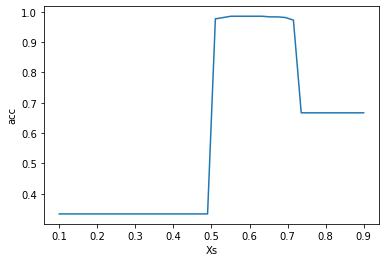

In [12]:
pred, tar = model.get_preds()
xs = torch.linspace(.1, .9, 40)
acc = [accuracy_multi(pred, tar, thresh=i) for i in xs]
plt.xlabel('Xs')
plt.ylabel('acc')
plt.plot(xs, acc)

In [22]:
model.metrics = partial(accuracy_multi, thresh=.6)
model.validate()

(#2) [0.07428628206253052,0.9850427508354187]

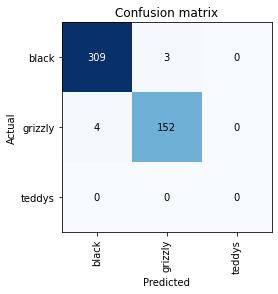

In [23]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix()

,target,predicted,probabilities,loss
0,black,grizzly,"tensor([6.4154e-04, 9.9996e-01, 8.8447e-05])",5.858524322509766
1,black,grizzly,"tensor([1.2957e-02, 9.4579e-01, 8.6048e-04])",2.420614242553711
2,grizzly,black,"tensor([9.6446e-01, 5.8901e-02, 1.9551e-04])",2.056353807449341
3,grizzly,,"tensor([0.1458, 0.2668, 0.0033])",0.4940844774246216


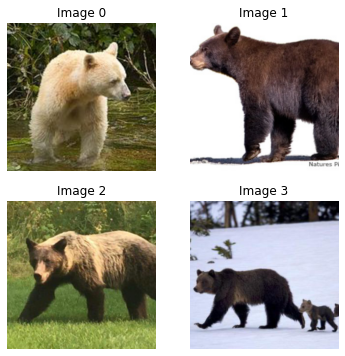

In [15]:
interp.plot_top_losses(4)

### exporting model

In [33]:
model.export(fname = Path.cwd()/'../models/bear.pkl')

In [4]:
model_loaded = load_learner(Path.cwd()/'../models/bear.pkl')

In [3]:
from fastai.vision.widgets import FileUpload

upload = FileUpload()
upload

FileUpload(value={}, description='Upload')

In [ ]:
img = PILImage.create(upload.data[0])
img.to_thumb(300)

In [9]:
pred, _, tar = model_loaded.predict(upload.data[0])
str(','.join(pred))

'black'

In [32]:
torch.argmax(tar)

tensor(0)

In [38]:
model.predict(img)

((#1) ['grizzly'],
 tensor([False,  True, False]),
 tensor([0.3351, 0.8255, 0.2923]))

In [42]:
model.metrics = partial(accuracy_multi, thresh=.0001)
model.predict(img)

((#1) ['grizzly'],
 tensor([False,  True, False]),
 tensor([0.3351, 0.8255, 0.2923]))

In [47]:
dsets = bears.datasets(path)

x, y = dsets.train[0]
x, y

(PILImage mode=RGB size=497x500, TensorMultiCategory([0., 1., 0.]))

In [48]:
def accuracy_multi(inp, targ, thresh=.5, sigmoid=True):
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()